What this notebook does:

Each coffee shop review was assigned 5 topic scores for 5-topic LDA Model identified in './LDA_Fitting/LDA_onreviews_nouns_withhptuning.ipynb'. This notebook explores the distribution of the topic importance scores across reviews

To examine the structure of topic importance vectors, hierarchical clustering of these vectors is performed and the average of each cluster is plotted.

5-topic LDA vectors for reviews are visualized by considering the first 2 principal components. There are clear differences in the distribution of these vectors for different coffee shops.

The distribution of topic importances across all reviews is visualized for each of the 5 topics.

In [ ]:
#Step one directory up to access the yelp scraping function in the helper_functions module
import os
print(os.getcwd())
os.chdir('../')
os.getcwd()

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

topiclabels = ['Coffee','Setting','Service','Food','Sweets']


ModuleNotFoundError: No module named 'sklearn'

In [2]:
shops = pd.read_csv('./ProcessedData/coffeeshops_withcfcutoff.csv')
reviews = pd.read_csv('./LDAresults/ldatopicweights_allreviews_5topics.csv')
merged = pd.merge(shops,reviews,how='inner',on = ['alias'])


In [21]:
#How is the review data distributed in the LDA topic space?
#Is there a most common type of review?
#What does the distribution look like for different types of coffee shops?
#Are reviews for the same coffee shop in a chain generally closer to one another? This would indicate that 
#What people write about in a review depends what the coffee shop serves
mergedsmall = merged.sample(n=5000)
mergedsmall.reset_index(inplace=True,drop=True)
ldavecs = mergedsmall[['t0','t1','t2','t3','t4']]


### Hierarchical clustering of 5-topic LDA review vectors

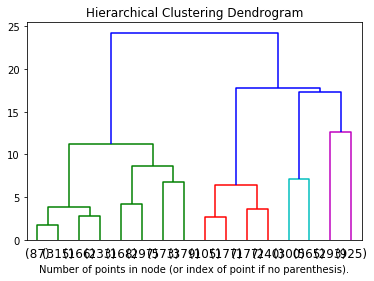

In [6]:
#Determining whether there is any structure to the distribution of LDA vectors.
#Do some topics tend to be correlated with others?
#How can we visualize the distribution of these probability vectors
#Is there a hierarchy to the clustering.  Are some classes of lda vector more similar to one 
#another than other groups? 
#K means works better with spherical clusters but the constraint that the vectors sum to 1 makes it unlikely for this to hold
#Use Euclidean distance because very big differences in a probability class should weigh more than
#many small differences.

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(ldavecs)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()



In [7]:
#Visualizing the mean and variance of individual clusters

model = AgglomerativeClustering(n_clusters=7)
labels = model.fit_predict(ldavecs)

3    952
1    925
0    865
5    801
2    699
6    465
4    293
Name: labels, dtype: int64
3    0.1904
1    0.1850
0    0.1730
5    0.1602
2    0.1398
6    0.0930
4    0.0586
Name: labels, dtype: float64
              t0        t1        t2        t3        t4
labels                                                  
0       0.105916  0.130785  0.162303  0.484320  0.114610
1       0.258786  0.517090  0.076728  0.068614  0.076703
2       0.130458  0.155866  0.598897  0.045123  0.067621
3       0.507219  0.162023  0.073174  0.110089  0.145427
4       0.079016  0.192298  0.135372  0.046040  0.545058
5       0.784377  0.041526  0.063047  0.052617  0.056696
6       0.407212  0.048979  0.376593  0.053439  0.111447
              t0        t1        t2        t3        t4
labels                                                  
0       0.109900  0.143809  0.182561  0.187080  0.134856
1       0.163912  0.160726  0.093142  0.076601  0.084960
2       0.114061  0.139620  0.161991  0.050288  0.070303

Text(0.5, 1.0, 'mean vector\ncluster 6')

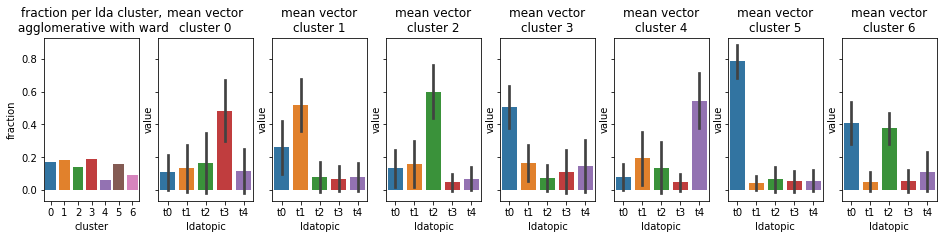

In [8]:
clusteredlda = ldavecs.copy()
clusteredlda['labels'] = labels
print(clusteredlda.labels.value_counts())
fracpercluster = clusteredlda.labels.value_counts()/len(clusteredlda)
print(fracpercluster)

#calculating the mean of vectors assigned to each cluster
clustermeans = clusteredlda.groupby('labels').mean()
print(clustermeans)
clusterstds = clusteredlda.groupby('labels').std()
print(clusterstds)

f, (ax1, ax2,ax3,ax4,ax5,ax6,ax7,ax8) = plt.subplots(1, 8, sharey=True, figsize = (16,3))
sns.barplot(x=fracpercluster.index,y=fracpercluster, ax=ax1)
ax1.set_title('fraction per lda cluster,\n agglomerative with ward')
ax1.set_ylabel('fraction')
ax1.set_xlabel('cluster')

clustermeans.reset_index(inplace=True)
longdf = clusteredlda.melt(id_vars=['labels'])
longdf.rename(columns={'variable':'ldatopic'},inplace=True)
print(longdf.head(10))
print(longdf[longdf.labels==0].head(10))

sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==0],ax=ax2,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==1],ax=ax3,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==2],ax=ax4,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==3],ax=ax5,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==4],ax=ax6,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==5],ax=ax7,ci="sd")
sns.barplot(x="ldatopic",y="value",data=longdf[longdf.labels==6],ax=ax8,ci="sd")

ax2.set_title('mean vector\ncluster 0')
ax3.set_title('mean vector\ncluster 1')
ax4.set_title('mean vector\ncluster 2')
ax5.set_title('mean vector\ncluster 3')
ax6.set_title('mean vector\ncluster 4')
ax7.set_title('mean vector\ncluster 5')
ax8.set_title('mean vector\ncluster 6')


The clustering based on Ward/Euclidean distance finds clusters which are primarily disstinguished by the most popular topic.    THe most common cluster is the one in which the coffee topic is strongest, followed by the one  in which the line/time topic.   In the cluster in which the mean food score is highest, the next strongest topics are not far behind.

### Distribution of each topic component across all coffee shop reviews

Plotting the distribution of each topic vector component
For each topic there is a large proportion of reviews with and lda score of 0 for that topic


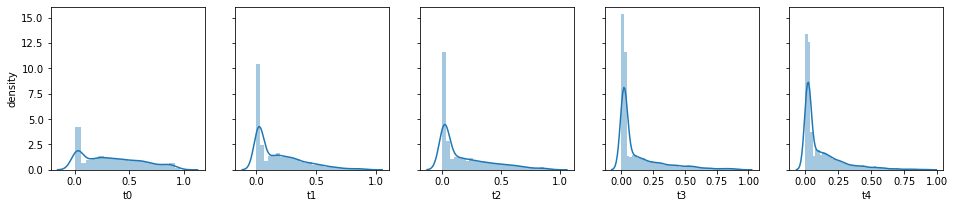

In [9]:
#Plotting the distribution of each lda vector component alone
f, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1, 5, sharey=True, figsize = (16,3))
sns.distplot(ldavecs['t0'],ax=ax1)
sns.distplot(ldavecs['t1'],ax=ax2)
sns.distplot(ldavecs['t2'],ax=ax3)
sns.distplot(ldavecs['t3'],ax=ax4)
sns.distplot(ldavecs['t4'],ax=ax5)

ax1.set_ylabel('density')
print('Plotting the distribution of each topic vector component')
print('For each topic there is a large proportion of reviews with and lda score of 0 for that topic')

### VIsualizing the distribution of LDA vectors for reviews, plot the first 2 principal components. Comparing distribution of reviews for different coffee shops.

In [25]:
#Plotting the first principal components
ldavecs = merged[['t0','t1','t2','t3','t4']]
X = np.array(ldavecs.values.tolist())
pca = PCA(n_components=3)
pca.fit(X)
Xtransf = pca.transform(X)

Starbucks             7615
Dunkin'               1648
Gregorys Coffee       1584
Pret A Manger         1485
Bluestone Lane        1066
Le Pain Quotidien      957
Joe Coffee Company     728
La Colombe Coffee      620
JOE & THE JUICE        616
Think Coffee           524
Name: name, dtype: int64

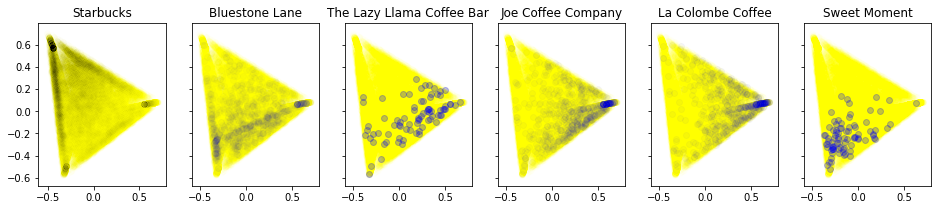

In [33]:
shopstoplot = ['Starbucks','Bluestone Lane', 'The Lazy Llama Coffee Bar', 'Joe Coffee Company','La Colombe Coffee','Sweet Moment']

f, ax = plt.subplots(1, 6, sharey=True, figsize = (16,3))
for i in range(6):
    ax[i].scatter(x=Xtransf[:,0],y=Xtransf[:,1],c='yellow',cmap=matplotlib.colors.ListedColormap(colors),alpha=0.01)
    Xbsl = np.array([Xtransf[k] for k in range(len(Xtransf)) if merged.name[k] == shopstoplot[i]])
    ax[i].scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='blue',alpha = 1/len(Xbsl)*20)
    ax[i].set_title(shopstoplot[i])


merged.name.value_counts().head(10)

AttributeError: 'AxesSubplot' object has no attribute 'set_legend'

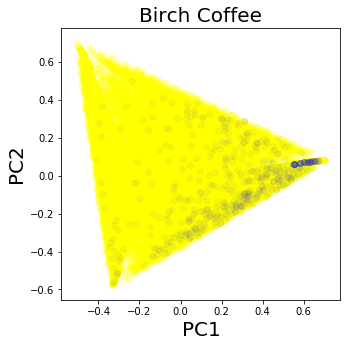

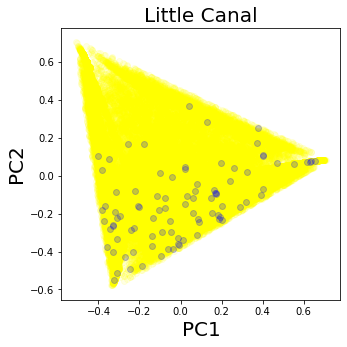

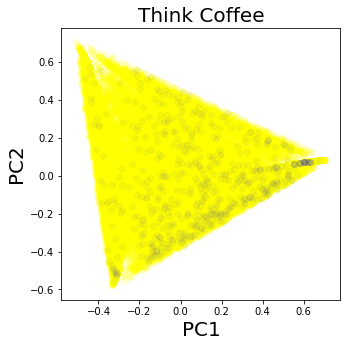

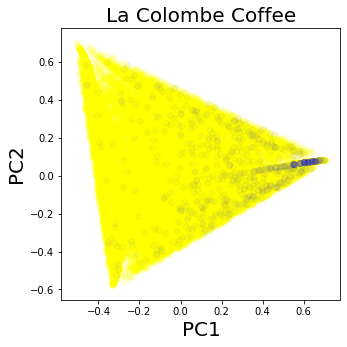

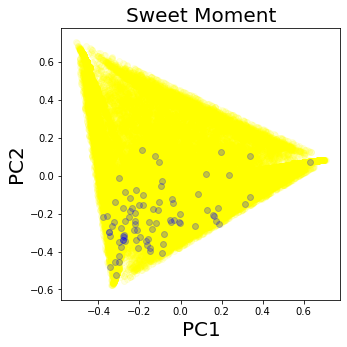

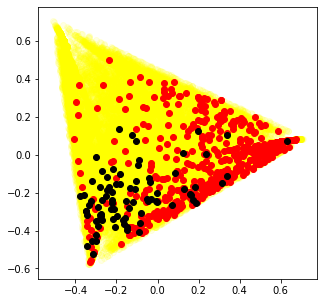

In [32]:
#Saving PCA plots of the review lda topic vectors

shopnames = ['Birch Coffee','Little Canal','Think Coffee','La Colombe Coffee','Sweet Moment']

for name in shopnames:
    f1,ax1 = plt.subplots(1, 1, sharey=True, figsize = (5,5))
    ax1.scatter(x=Xtransf[:,0],y=Xtransf[:,1],c='yellow',cmap=matplotlib.colors.ListedColormap(colors),alpha=0.1)
    Xbsl = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == name])
    ax1.scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='blue',alpha = 1/len(Xbsl)*20)
    ax1.set_title(name,fontsize=20)
    ax1.set_xlabel('PC1',fontsize=20)
    ax1.set_ylabel('PC2',fontsize=20)
    f1.savefig('./Figures/LDA/PCA_' + name + '.png',bbox_inches='tight')

    
f1,ax1 = plt.subplots(1, 1, sharey=True, figsize = (5,5))
ax1.scatter(x=Xtransf[:,0],y=Xtransf[:,1],c='yellow',cmap=matplotlib.colors.ListedColormap(colors),alpha=0.1)
Xbsl = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == 'Birch Coffee'])


pt1 = ax1.scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='red',alpha = 1)
Xbsl = np.array([Xtransf[i] for i in range(len(Xtransf)) if merged.name[i] == 'Sweet Moment'])
pt2 = ax1.scatter(x=Xbsl[:,0],y=Xbsl[:,1],c='black',alpha = 1)
ax1.set_legend((pt1,pt2), ('Birch Coffee', 'Sweet Moment'))


ax1.set_title('',fontsize=20)
ax1.set_xlabel('PC1',fontsize=20)
ax1.set_ylabel('PC2',fontsize=20)
ax1.set_legend('coffee')
f1.savefig('./Figures/LDA/PCA_sweetmoment_birch.png',bbox_inches='tight')


Different coffee shops clearly have different distributions of topics in their reviews.  The first principal components has a positive coefficient for coffee related terms (t3), and negative for other terms, especially those related to topic 2 (time, location, morning).    The second principal component is positive for topic 0 (place, table, work, space, seat), and most negative for topic 2(time, location, morning).  It seems like pc2 describes time spent at the place, and pc1 reflects focus on coffee in the review.  The third principal component has t1 (food, sandwiches, breakfast, bread) and t4 (tea, chocolate, flavor, taste) with positive coefficients and t0 (table, work, space) has the most negative component. Together, these 3 principal components explain 85% of the variability in the data set.

In [10]:
print(pca.components_)
print(pca.explained_variance_ratio_)

[[ 0.84620999 -0.19016943 -0.02467399 -0.15985769 -0.4707451 ]
 [-0.19159433  0.73704761  0.15554814 -0.07571709 -0.62459918]
 [-0.13383161 -0.29237299 -0.01565984  0.85278753 -0.41123635]]
[0.42380627 0.25593181 0.1840463 ]


### Looking at the full distribution of the coffee topic importance for reviews of a handful of selected shops

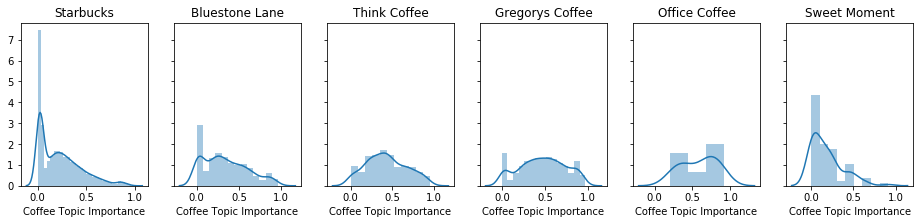

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 6, sharey=True, figsize = (16,3))
shoplabels = ['Starbucks','Bluestone Lane','Think Coffee','Gregorys Coffee','Office Coffee','Sweet Moment']

for i in range(6):
    sns.distplot(ldavecs[merged.name==shoplabels[i]].t0,ax=ax[i], kde = True)
    ax[i].set_title(shoplabels[i])
    ax[i].set_xlabel('Coffee Topic Importance')